# Dispute Resolution Mechanism (Numerical Simulation)
Author: Mingxuan @ Nethermind  
This Python notebook computes & plots relevant variables in response to input parameters within the dispute resolution mechanism.  

In [ ]:
%%capture
!pip install solara # visualization interface

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import solara

## Global parameters

### For court design and detection


Court fees ($C$) in ETH: preset 0.25 ETH

In [ ]:
C = 0.25


Court true positive probability ($p_{CTP}$), Court false positive probability ($p_{CFP}$): preset 0.85, 0.10

In [ ]:
p_ctp = 0.85
p_cfp = 0.1

Detection true positive time ($t_{DTP}$), Detection false positive time ($t_{DFP}$): preset 6, 114 months

In [ ]:
t_dtp = 6
t_dfp = 114

### ETH economic parameters

Staking yield (APR): preset 6.5%

In [ ]:
apr = 0.065

Mean value of USD/ETH exchange rate $\Xi^{-1}$: preset $2000=1ETH

In [ ]:
Xi_inverse = 1/2000

### Node operator revenue and cost parameters

Operator reward percentage (Lido): preset 5%

In [ ]:
operator_pctg = 0.05

In [ ]:
r = 32 * apr * operator_pctg / 12

Fixed cost of white labeling ($\tilde{c}_w$) in dollars: preset $5

In [ ]:
tilde_cw = 5

White-labeling commission in %: preset 3%

In [ ]:
commission_wl = 0.03

Cost of white-labeling services. There're two models here:  
If fixed_cost_in_dollars==True: flat monthly rate in dollars   
If fixed_cost_in_dollars==False: service commission on the APR  

In [ ]:
fixed_cost_in_dollars = True
c_w = tilde_cw * Xi_inverse if fixed_cost_in_dollars else r*commission_wl

Cost of honest operator in dollars ($c_h$): preset $1500

In [ ]:
c_h_dollars = 1500
c_h = c_h_dollars * Xi_inverse

## Tunable parameters

Reward to accuser's bond ratio ($\alpha$), restricted to $\frac{1-p_\text{CTP}}{p_\text{CTP}}< \alpha<\frac{1-p_\text{CFP}}{p_\text{CFP}}$

In [ ]:
alpha = 2

In [ ]:
a_max = (1-p_cfp) / p_cfp
a_min = (1-p_ctp) / p_ctp
if not a_min < alpha < a_max:
  raise ValueError(f"alpha is out of bounds ({a_min}, {a_max})")

## Expected profit for all parties

### Expected return for an accuser (per court instance)
$$\text{successful case: } \frac{\Pi_T}{A} =(\alpha +1) \cdot p_{CTP}-1$$

$$\text{failed case: }\frac{\Pi_F}{A} = (\alpha +1) \cdot p_{CFP}-1$$

In [ ]:
accuser_return_t = (alpha + 1) * p_ctp - 1
accuser_return_f = (alpha + 1) * p_cfp - 1
print("Expected return for an honest case: " + str(100*accuser_return_t) + "%")
print("Expected return for a dishonest case: " + str(100*accuser_return_f) + "%")

Expected return for an honest case: 154.99999999999997%
Expected return for a dishonest case: -70.0%


### Expected profit for a white-label operator (per court instance)

Lower bound on accuser's reward $R(n)$ for a perfect court:
$$ R(n) > (r-c_{w})\cdot \tau_{DTP}\cdot n -C$$

Lower bound on accuser's reward $R(n)$ for an imperfect court:
$$ R(n) > \frac{(r-c_{w})\cdot \tau_{DTP}\cdot n -C}{p_{CTP} - \frac{1}{\alpha}(1-p_{CTP})} $$

In [ ]:
max_n = 10
n_range = np.arange(1,max_n+1)
R_min_perf = (r-c_w) * t_dtp * n_range - C
R_min_imperf = R_min_perf / (p_ctp - (1-p_ctp)/alpha)

### Expected profit for an honest operator

Lower bound on accuser's reward:
$$R(n) > \frac{C+c_h - r \cdot\tau_{DFP}\cdot n}{\frac{1}{\alpha}(1-p_\text{CFP})-p_\text{CFP}}$$

In [ ]:
R_min_honest = (C + c_h - r*t_dfp*n_range) / ((1-p_cfp)/alpha - p_cfp)

In [ ]:
R_min_aggregate = np.maximum.reduce([R_min_perf, R_min_imperf, R_min_honest, np.zeros(max_n)])

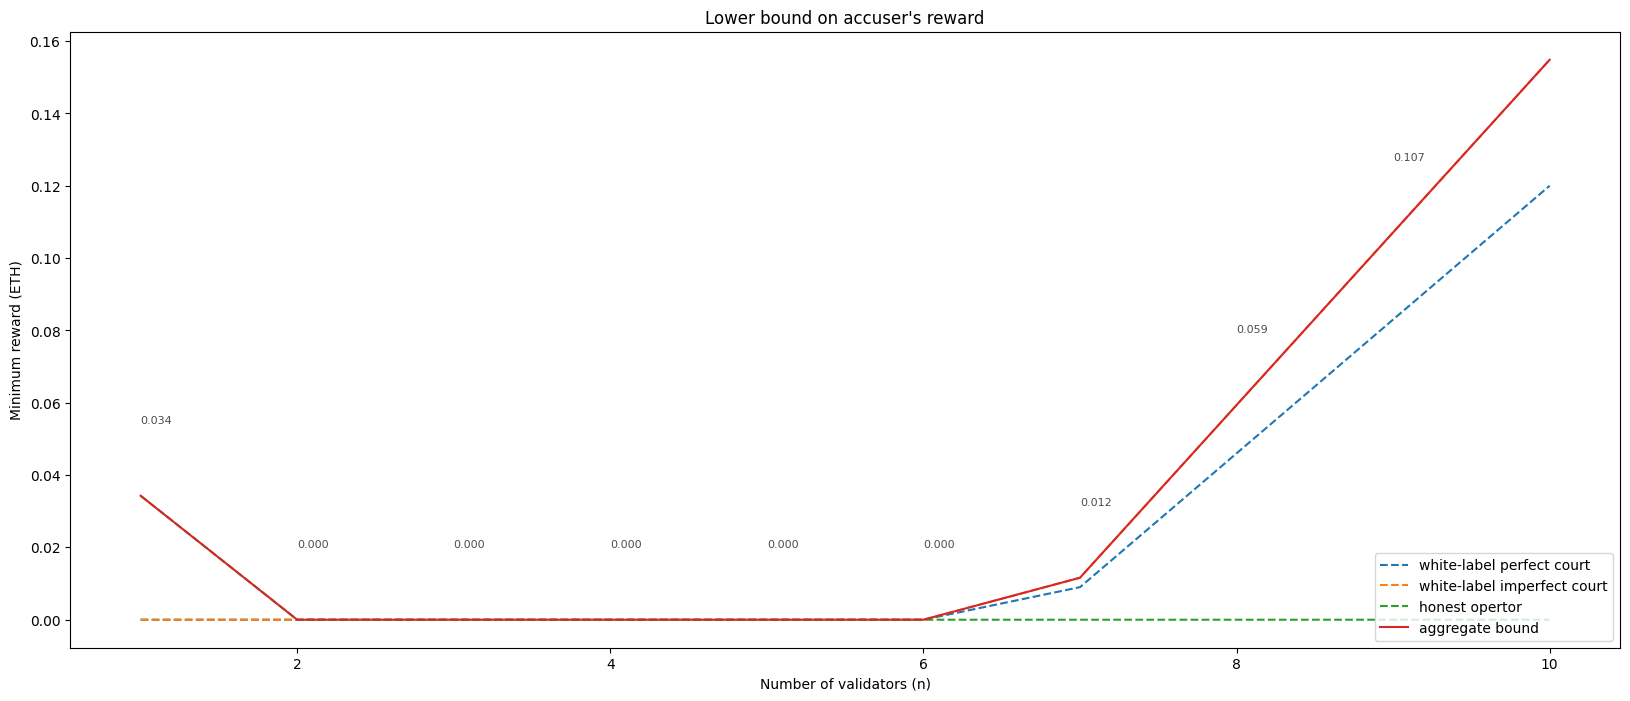

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(n_range, np.maximum.reduce([R_min_perf, np.zeros(max_n)]), '--', label='white-label perfect court')
plt.plot(n_range, np.maximum.reduce([R_min_imperf, np.zeros(max_n)]), '--', label='white-label imperfect court')
plt.plot(n_range, np.maximum.reduce([R_min_honest, np.zeros(max_n)]), '--', label='honest opertor')
plt.plot(n_range, R_min_aggregate, '-', label='aggregate bound')
for n, r in zip(n_range, R_min_aggregate):
    plt.annotate(f'{r:.3f}', (n, r + 0.02), fontsize=8, alpha=0.7)
plt.xlabel('Number of validators (n)')
plt.ylabel('Minimum reward (ETH)')
plt.legend(loc='lower right')
plt.title("Lower bound on accuser's reward")
plt.show()